# Sensitivity to Laplacian viscosity at the Equator

Gustavo Marques (gmarques@ucar.edu)

Last update: 04/02/2020

## Forced ocean/sea-ice experiments 

* EXP#25: Like EXP19 with  updated sandbox (MEKE_GEOM_ALPHA = 0.08)
* EXP#28: Like EXP25 + KH_RES_FN_POWER = 4
* EXP#29: Like EXP25 + KH_RES_FN_POWER = 100

AH (biharmonic) and KH (Laplacian) lateral viscosities (+ GM and Redi) are estimated by the Mesoscale Eddy Kinetic Energy module ([MEKE](https://mom6.readthedocs.io/en/latest/api/generated/modules/mom_meke.html?highlight=meke#module-mom_meke
))


``RESOLN_SCALED_KH``, if true, the Laplacian lateral viscosity is scaled away when the first baroclinic deformation radius is well resolved.

``KH_RES_FN_POWER``, the power of dx/Ld in the Kh resolution function.  Any positive integer may be used, although even integers are more efficient to calculate.  Setting this greater than 100 results in a step-function being used. 

### Time averages:
Run for one JRA cycle, time averages done using last 30 years


### 1.1 Globally-averaged ocean properties

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.025',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.028',
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.029']
labels = ['EXP25', 'EXP28', 'EXP29']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot
grd = MOM6grid('/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002/run/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

Basemap module not found. Some regional plots may not function properly
MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029/run/*mom6.hm_*.nc


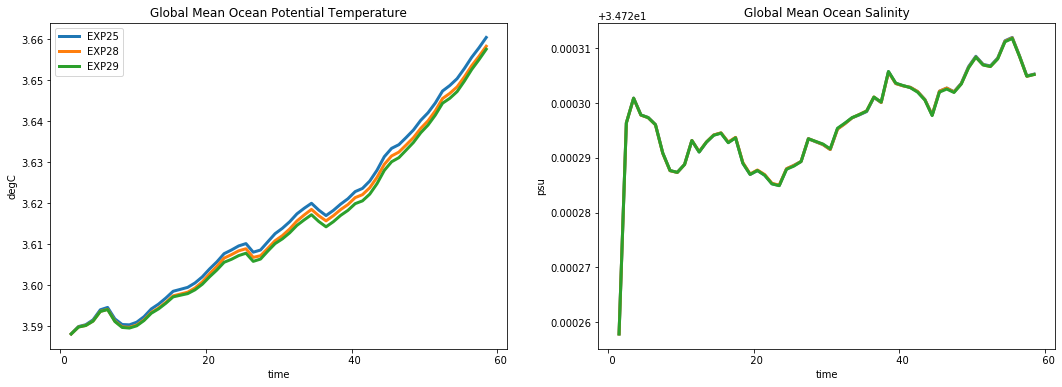

In [4]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = path+exps[i]+'/run/*mom6.hm_*.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds1 = ds.sel(time=slice('0001-01-01', '0080-01-01'))
  ds1['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds1['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds1.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds1.thetaoga.attrs['units'])
ax[1].set_title(ds1.soga.attrs['long_name']); ax[1].set_ylabel(ds1.soga.attrs['units']); ax[0].legend()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029/run/ocean.stats.nc


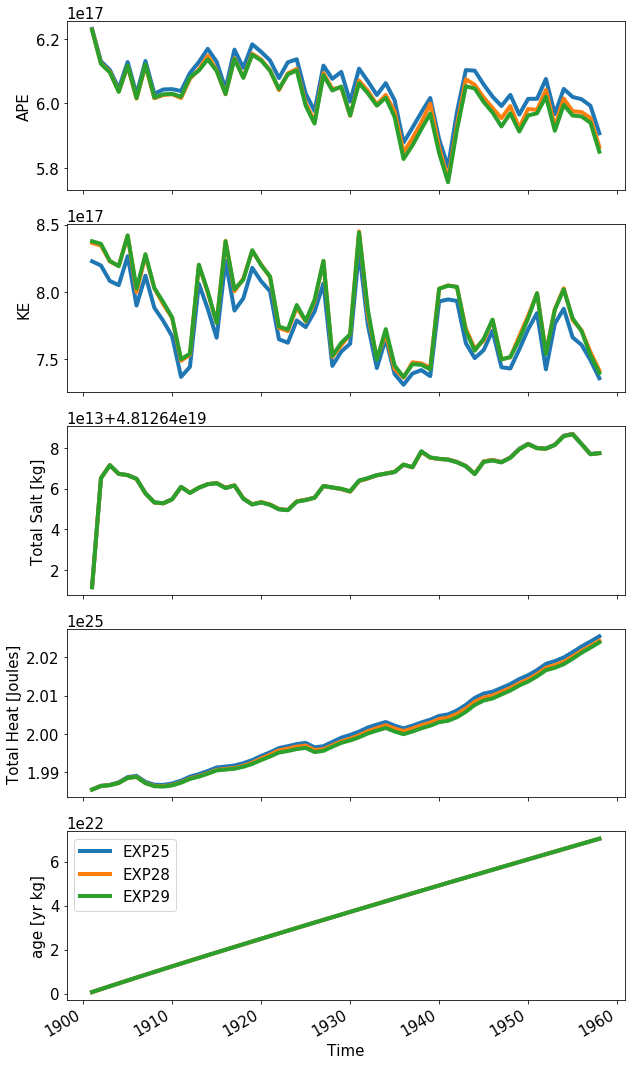

In [5]:
import pandas as pd
plt.rcParams.update({'font.size': 15})
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,18), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')

  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1Y", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True)   
  ds2 = ds1.sel(Time=slice('1900-01-01', '1980-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=4)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

### 1.2 Mixed layer depth

In [6]:
from mom6_tools.m6plot import xyplot
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


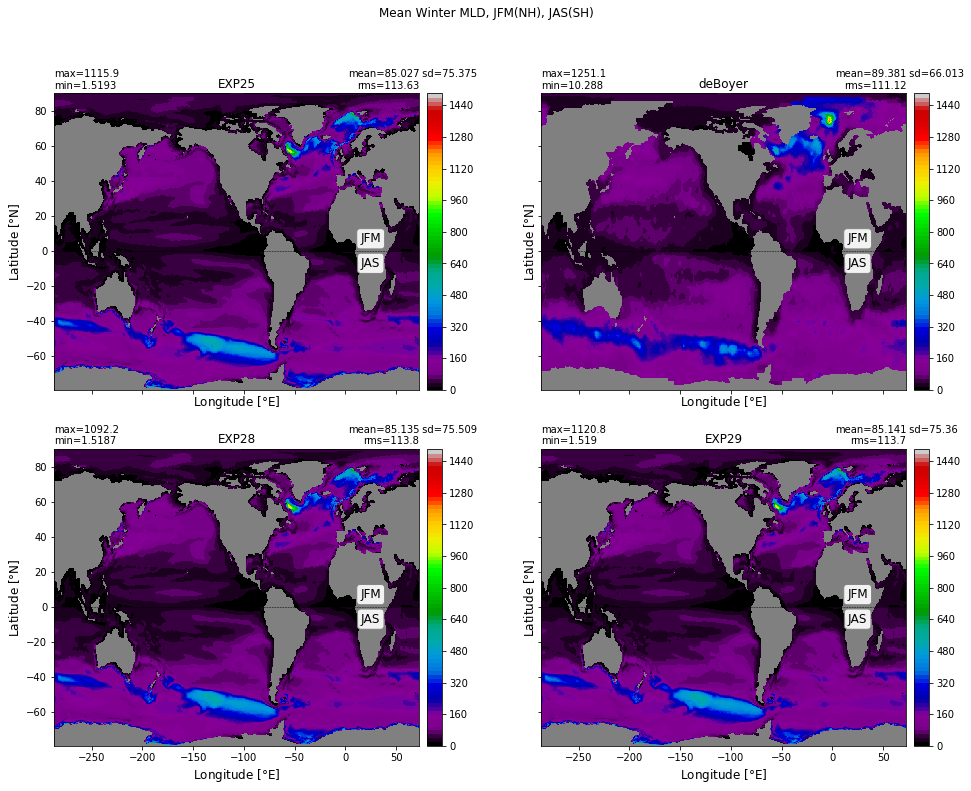

In [7]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

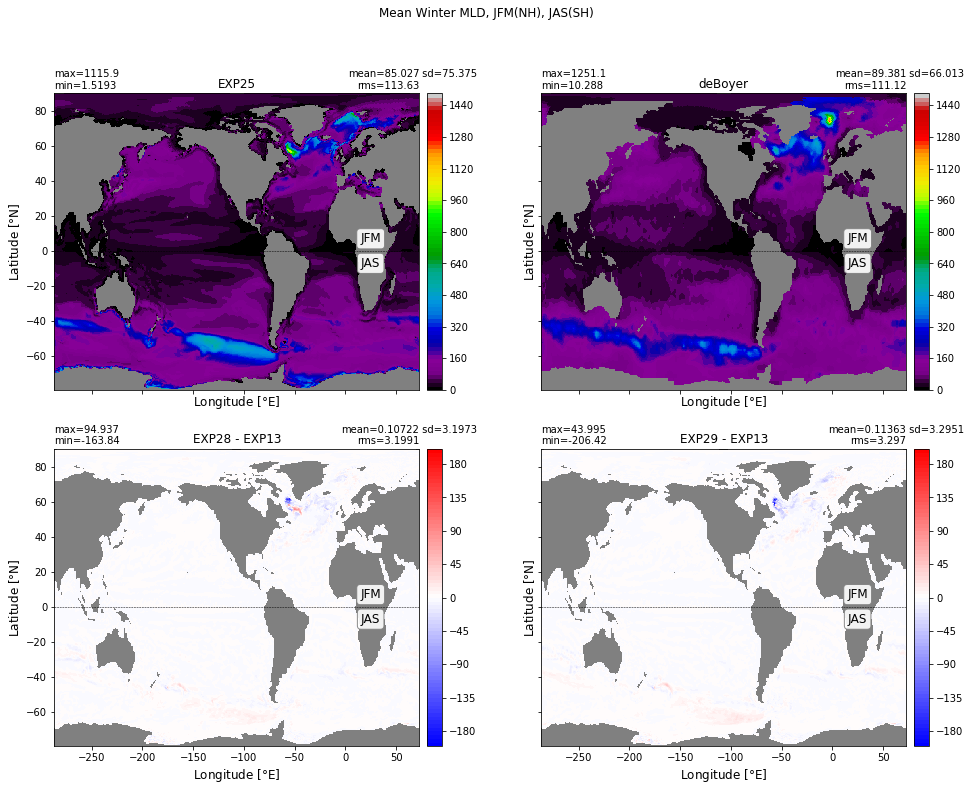

In [8]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - EXP13', axis=ax1[i+1], clim=(-200,200),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

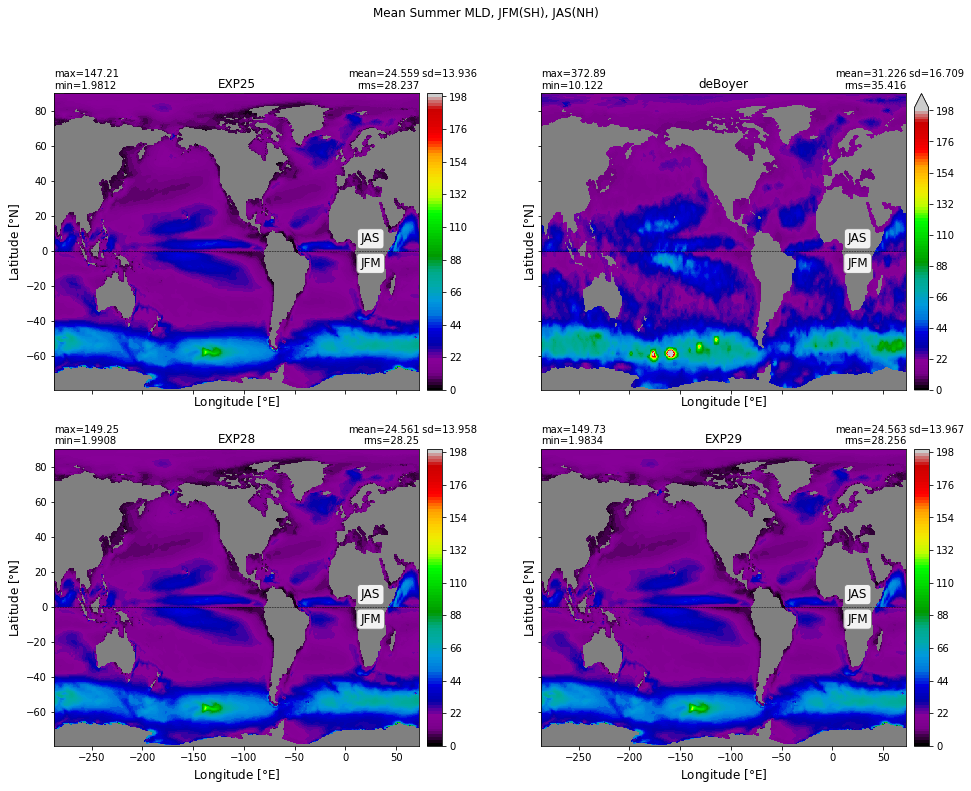

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

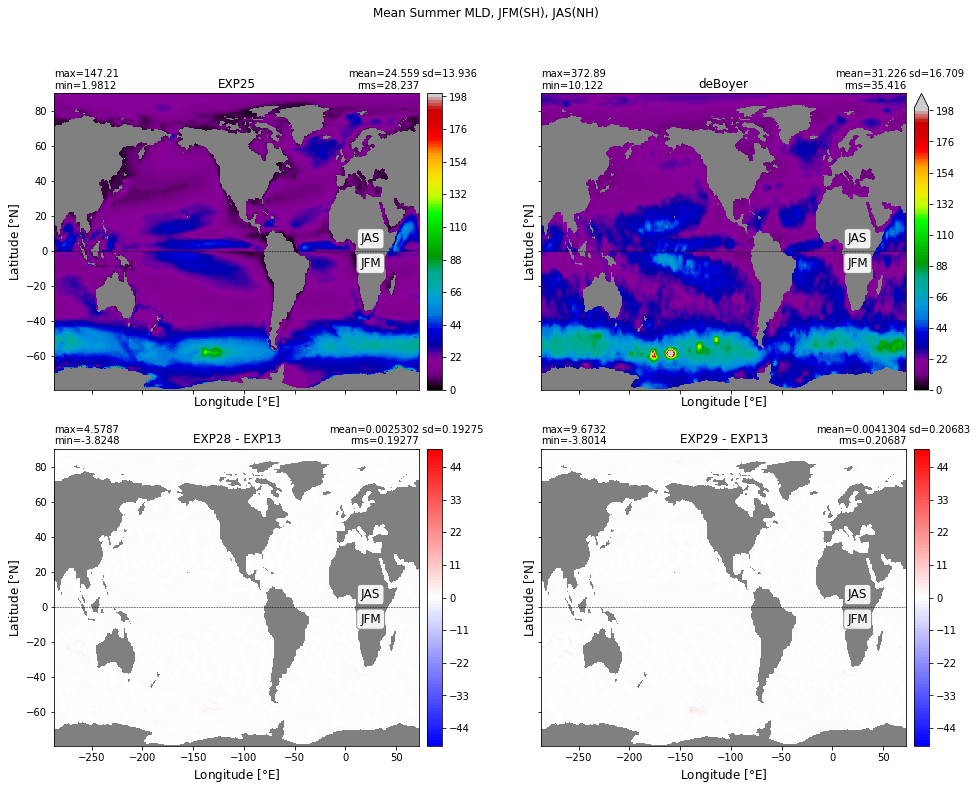

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) - control
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + ' - EXP13', axis=ax1[i+1], clim=(-50,50),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=100); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

###  1.3 Poleward Heat Transport

In [11]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

In [12]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

<center> <font size="4">Global Heat Transport</font>

(-2.5, 2.5)

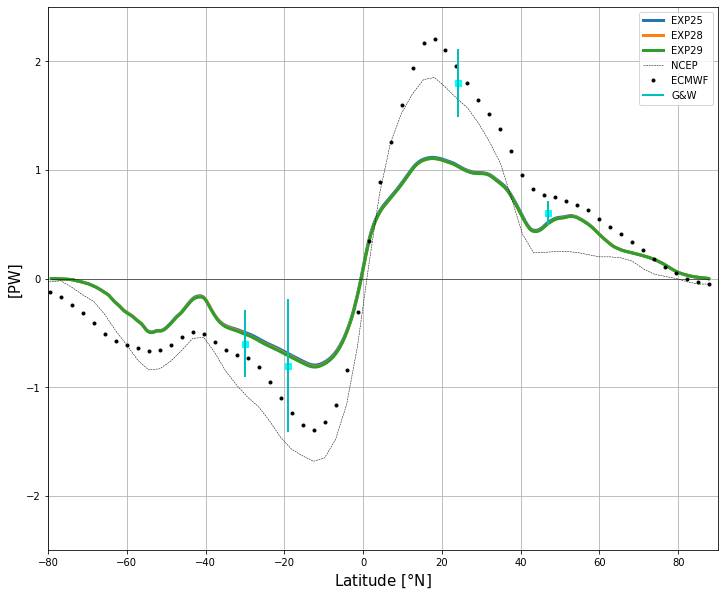

In [13]:
# Global Heat Transport
plt.figure(figsize=(12,10))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(-2.5,2.5)

In [14]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth)

11.16427964664149 64.78854837178643 [391, 434]


<center> <font size="4">Atlantic Heat Transport</font>

(0, 1.8)

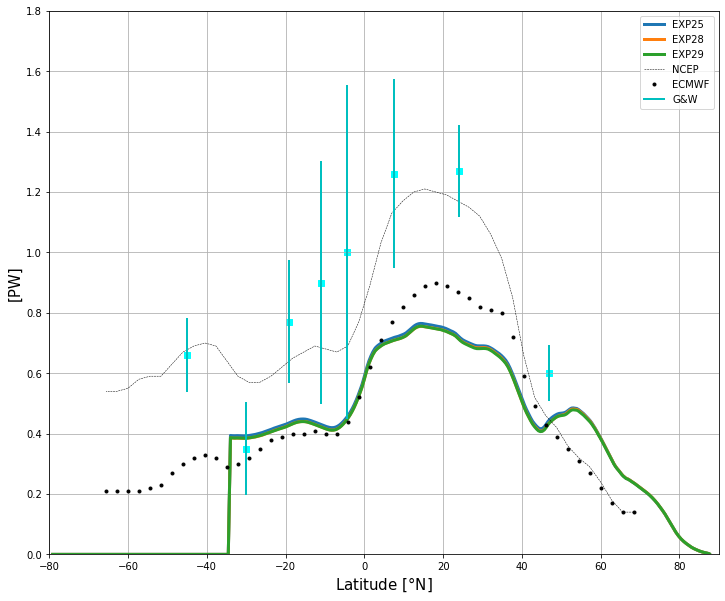

In [15]:
# Atlantic Heat Transport
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)] = 1
plt.figure(figsize=(12,10))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff, vmask=m*np.roll(m,-1,axis=-2)); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-0.1,2.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Atlantic'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Atlantic'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Atlantic']['lat'],GandW['Atlantic']['trans'],GandW['Atlantic']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(0,1.8)

### 1.4 Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_MOC_global.png'></td>
             <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.028/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028_MOC_global.png'></td></tr><tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.029/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029_MOC_global.png'></td>
    </tr>
</table>

<center> <font size="4">Atlantic</font></center>
<table><tr><td><img   src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_MOC_Atlantic.png'></td>
             <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.028/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028_MOC_Atlantic.png'></td></tr><tr>
             <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.029/PNG/MOC/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029_MOC_Atlantic.png'></td>
  </tr>
</table>

<center> <font size="4">AMOC time series @ 26N and 45N</font>

Text(0.5, 1.0, 'AMOC time series @ 45N')

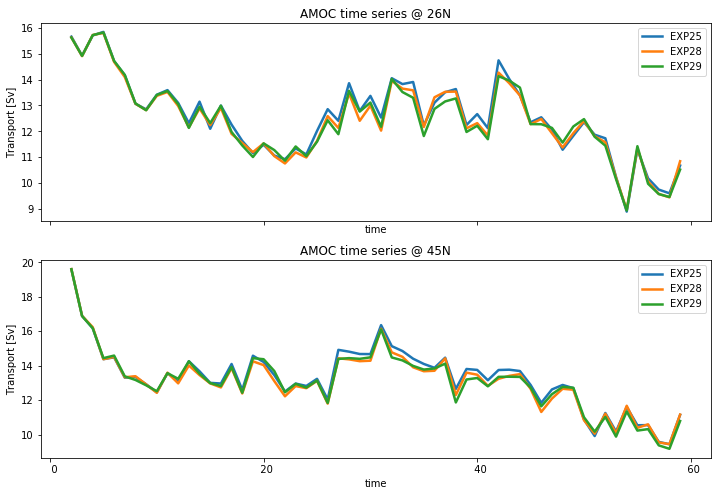

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
for i in range(len(exps)):
  ds1 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_26N_time_series.nc')
  ds1.__xarray_dataarray_variable__.plot(ax=ax[0], label=labels[i], lw=2.5)
  ds2 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_45N_time_series.nc')
  ds2.__xarray_dataarray_variable__.plot(ax=ax[1], label=labels[i], lw=2.5)

ax[0].set_ylabel('Transport [Sv]'); ax[0].legend(); ax[0].set_title('AMOC time series @ 26N')
ax[1].set_ylabel('Transport [Sv]'); ax[1].legend(); ax[1].set_title('AMOC time series @ 45N')

### 1.5 Transports

In [17]:
i=0
ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
ds.sections

<xarray.DataArray 'sections' (sections: 18)>
array(['Agulhas', 'Bab al mandeb Strait', 'Bering Strait', 'Barents Opening',
       'Davis Strait', 'Denmark Strait', 'Drake Passage', 'English Channel',
       'Florida-Bahamas', 'Fram Strait', 'Gibraltar Strait', 'Hormuz Strait',
       'Iceland-Norway', 'Indonesian Throughflow', 'Mozambique Channel',
       'Pacific Equatorial Undercurrent', 'Taiwan-Luzon Strait',
       'Windward Passage'], dtype=object)
Coordinates:
  * sections  (sections) object 'Agulhas' ... 'Windward Passage'

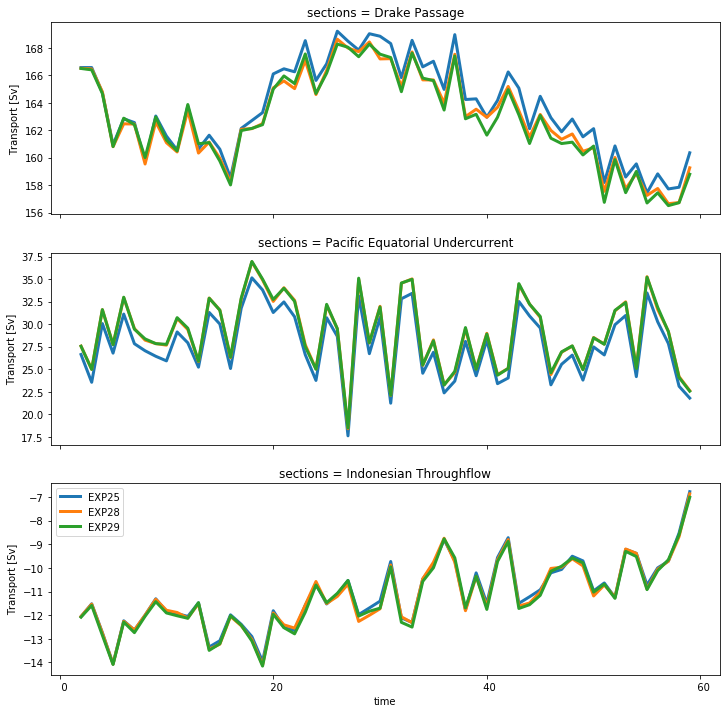

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,12), sharex=True)
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
  ds.transport.sel(sections='Drake Passage').plot(ax=ax[0], label=labels[i], lw=3)
  ds.transport.sel(sections='Pacific Equatorial Undercurrent').plot(ax=ax[1], label=labels[i], lw=3)
  ds.transport.sel(sections='Indonesian Throughflow').plot(ax=ax[2], label=labels[i], lw=3)
  
ax[0].set_ylabel('Transport [Sv]'); ax[0].set_xlabel('')
ax[1].set_ylabel('Transport [Sv]'); ax[1].set_xlabel('')
ax[2].set_ylabel('Transport [Sv]'); ax[2].legend()

### 1.6 Equatorial plots

<center> <font size="4">Equatorial_Global_temperature</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Global_temperature.png'></td></tr>
             <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028_Equatorial_Global_temperature.png'></td></tr> 
             <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029_Equatorial_Global_temperature.png'></td></tr>
</table>

<center> <font size="4">Equatorial_Global_salinity</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Global_salinity.png'></td></tr>
             <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028_Equatorial_Global_salinity.png'></td></tr> 
             <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029_Equatorial_Global_salinity.png'></td></tr>
</table>

<center> <font size="4">Equatorial_Pacific_uo</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025_Equatorial_Pacific_uo.png'></td></tr>
             <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.028_Equatorial_Pacific_uo.png'></td></tr> 
    <tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.029_Equatorial_Pacific_uo.png'></td></tr>
</table>

### 1.7 Horizontal Mean bias (w.r.t. obs) versus time

In [19]:
i=0
ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
#ds.region

### Global

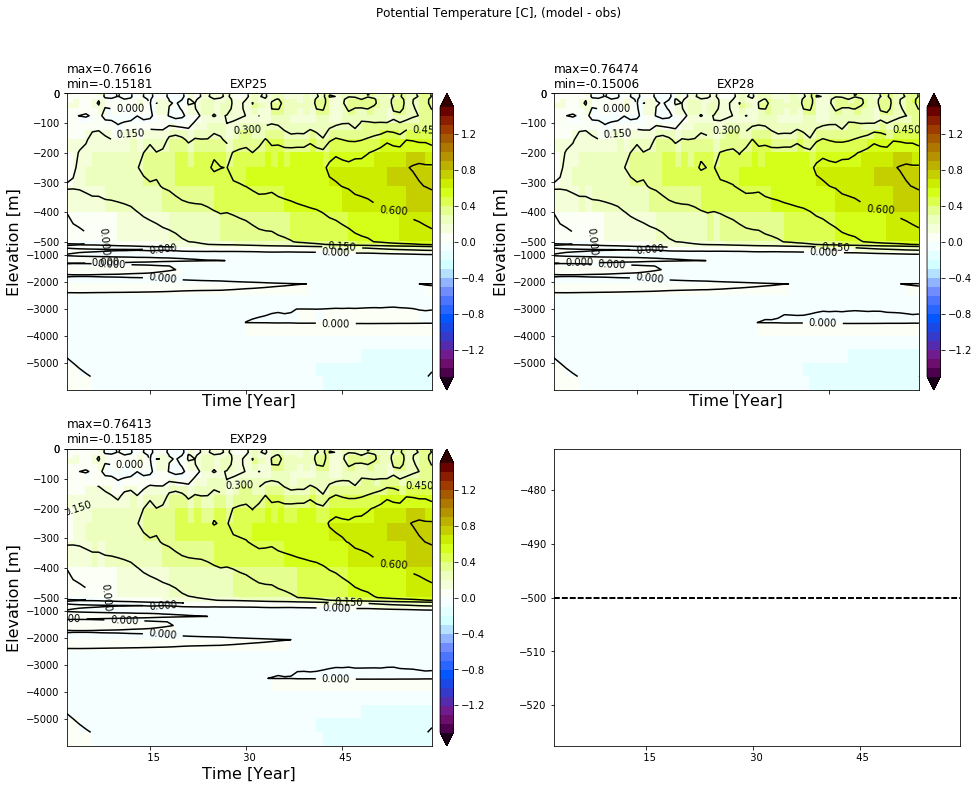

In [20]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1.5, 1.5)); 

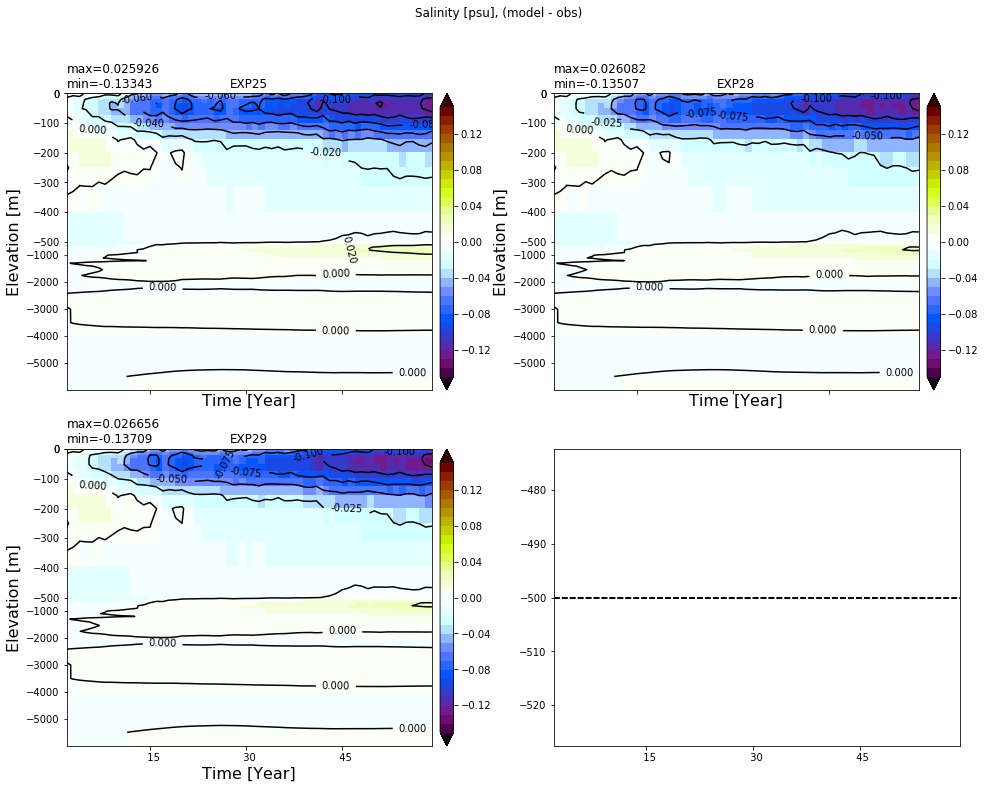

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.15, 0.15)); 

### Atlantic

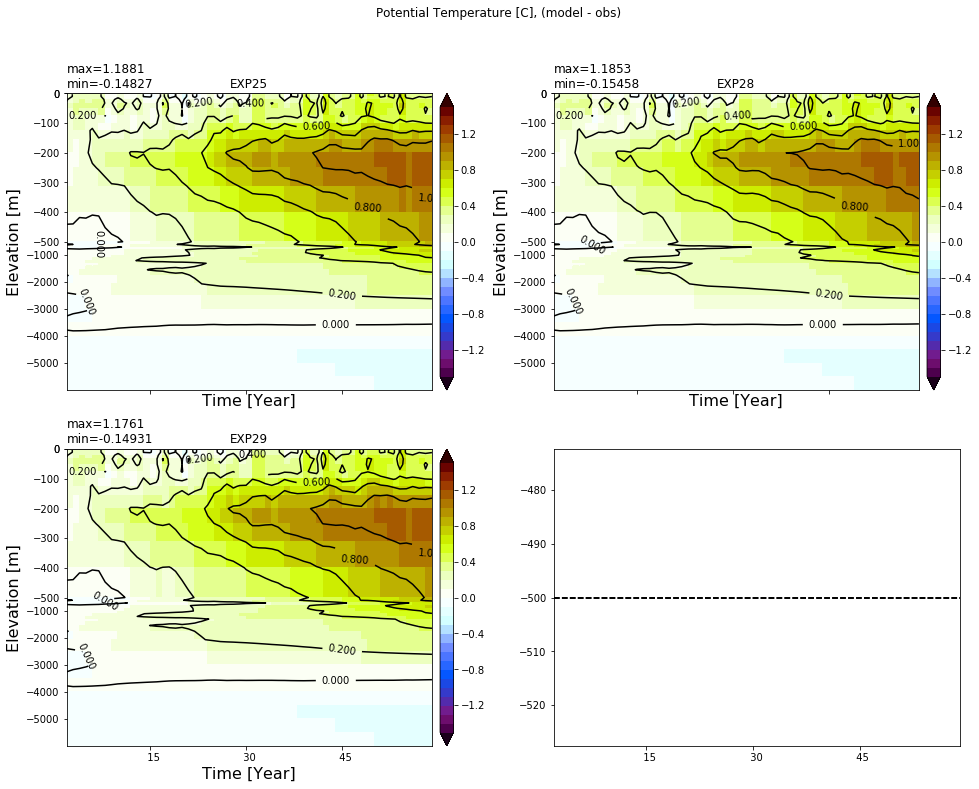

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1.5, 1.5)); 

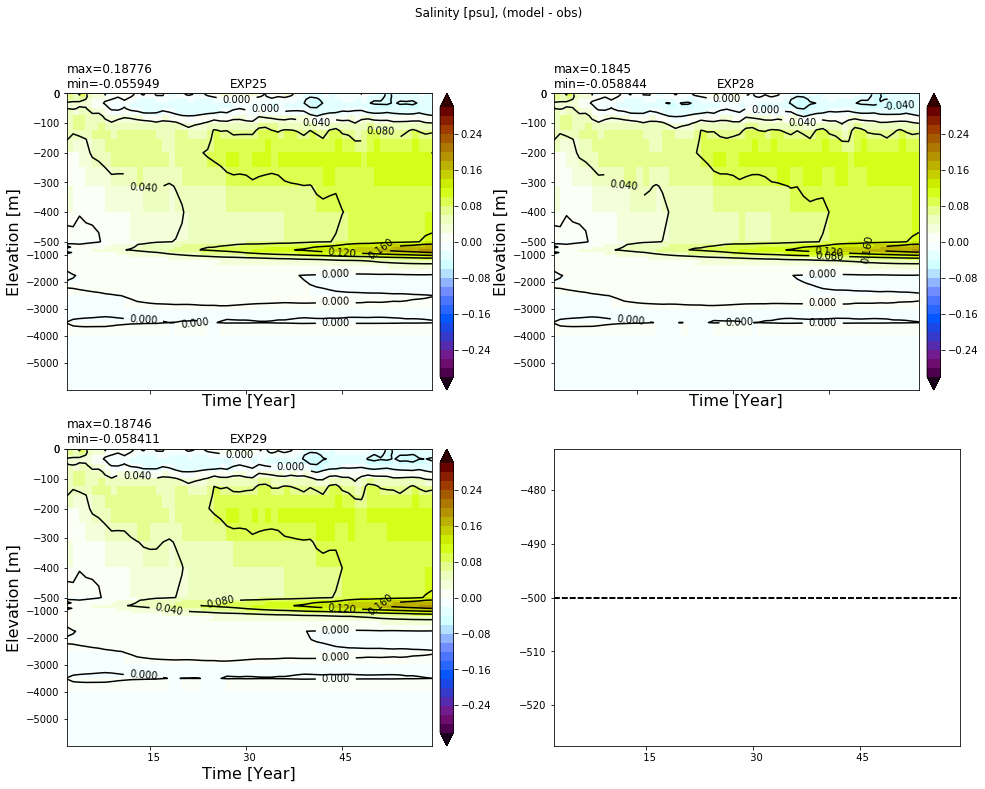

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.3)); 

### Pacific

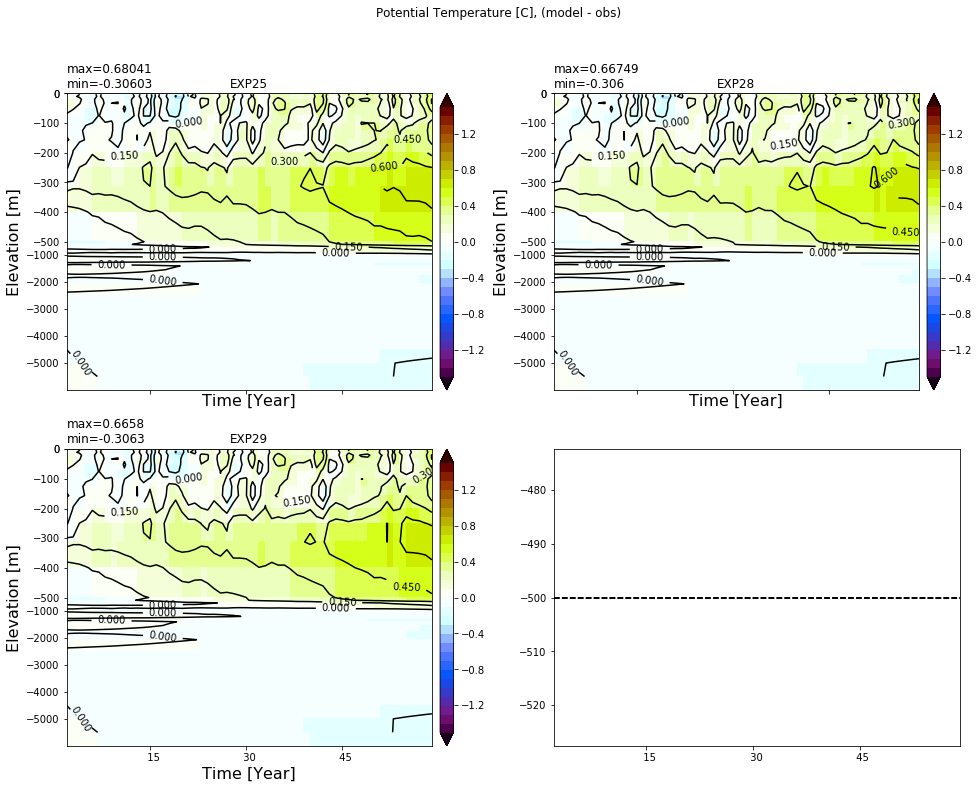

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-1.5, 1.5)); 

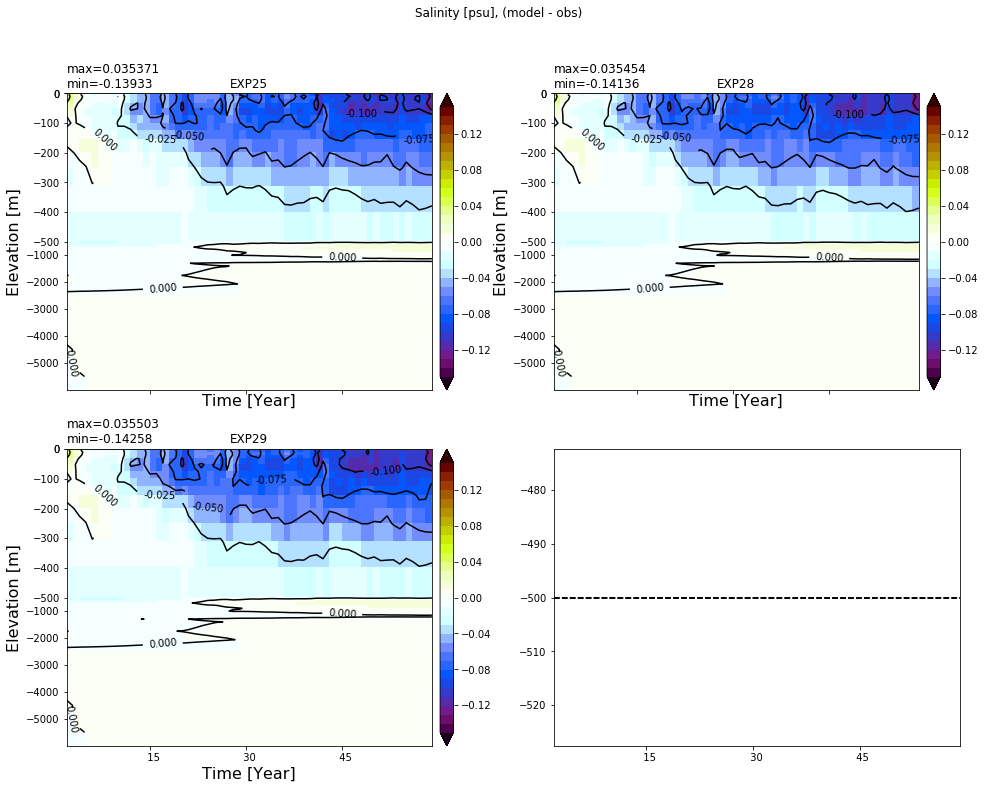

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.15, 0.15)); 

### Southern Ocean

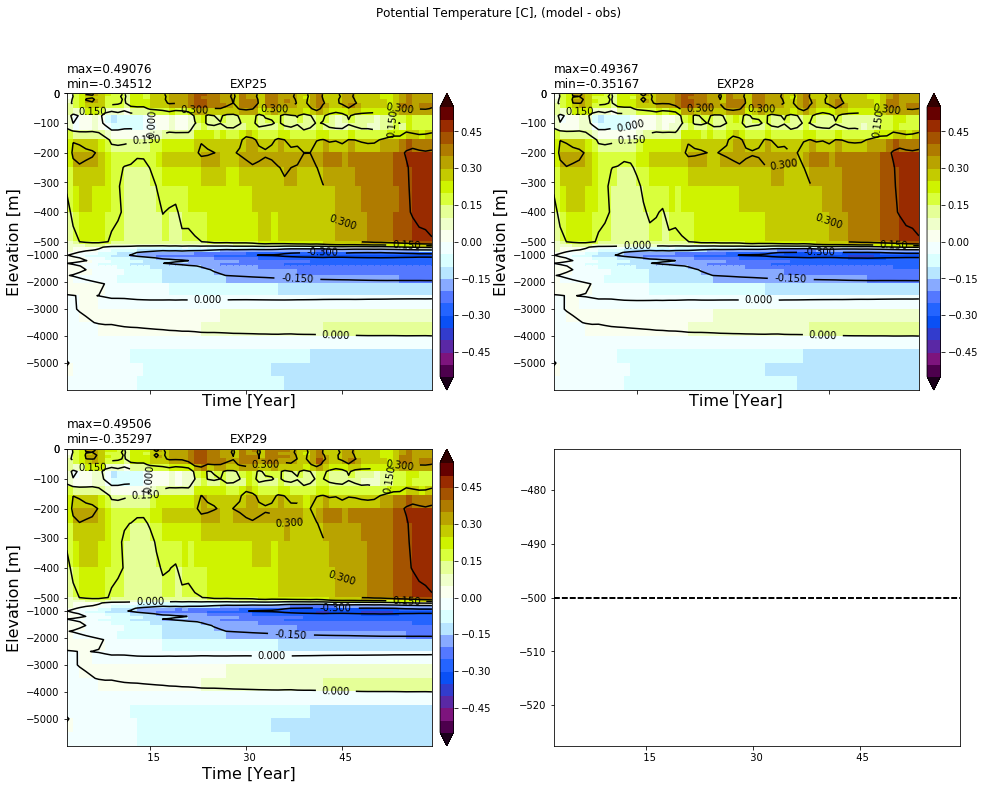

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='SouthernOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-.55, .55)); 

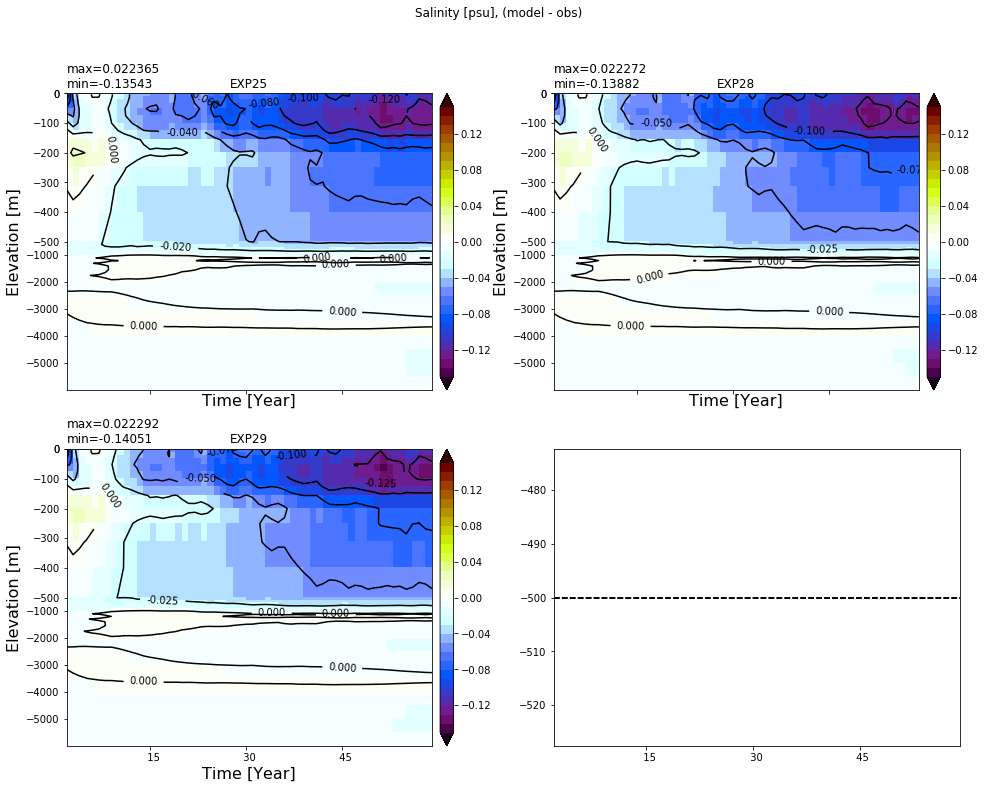

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='SouthernOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.15, 0.15)); 

### Arctic

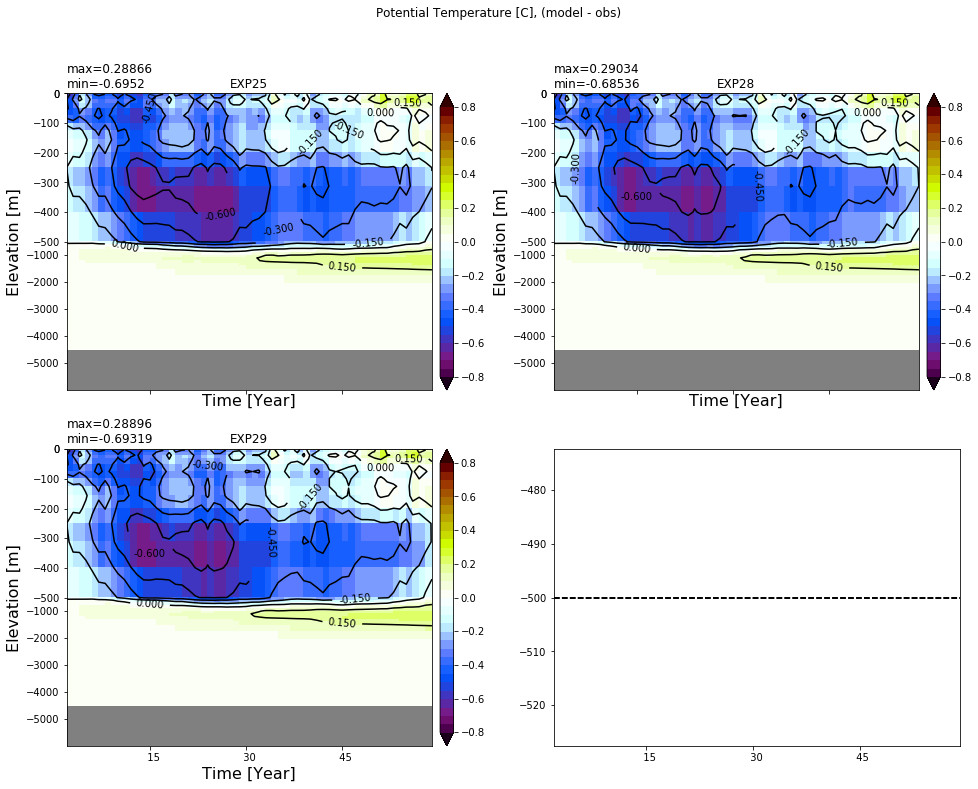

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Arctic').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-.8, .8)); 

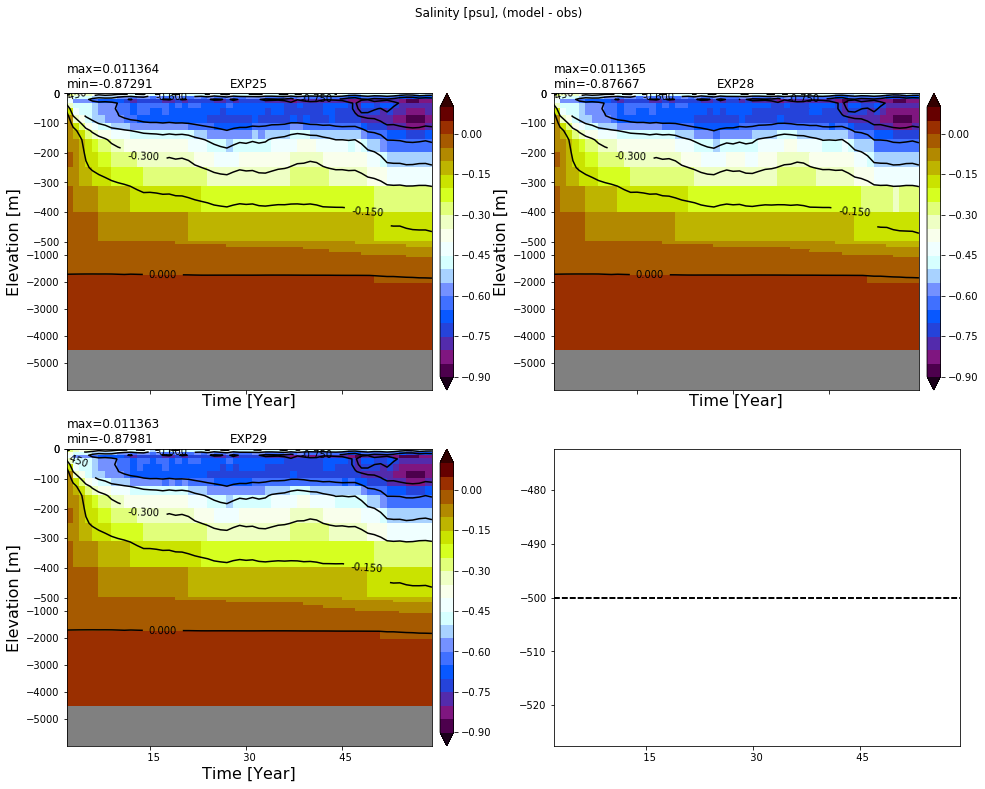

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True)
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Arctic').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.9, 0.1)); 

### 1.8 Mixing coefficients

In [4]:
from mom6_tools.m6plot import xyplot
%matplotlib inline
def get_data_sf(full_path):
  ds = xr.open_dataset(full_path)
  return ds
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo']

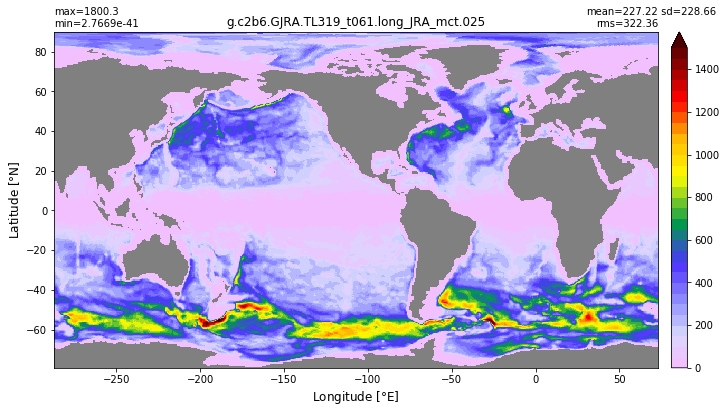

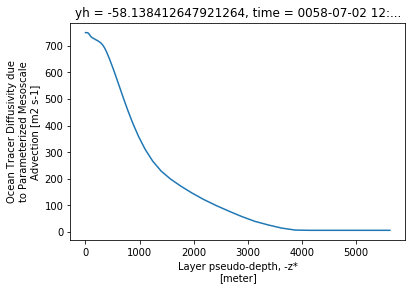

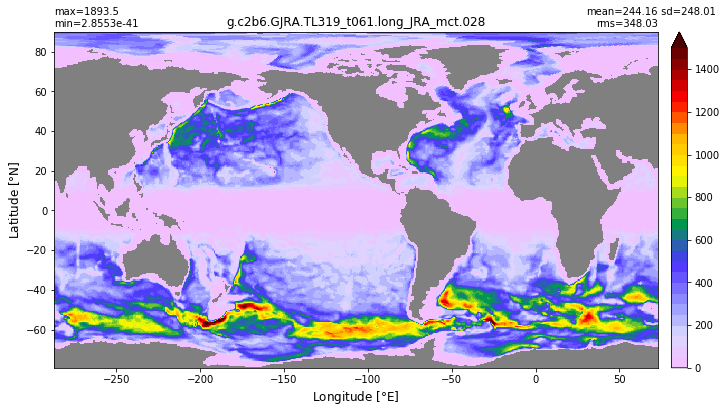

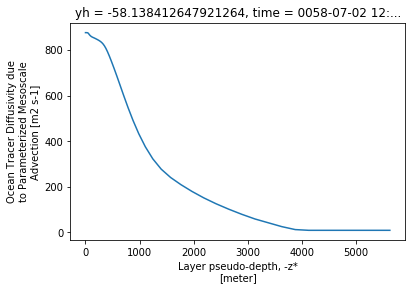

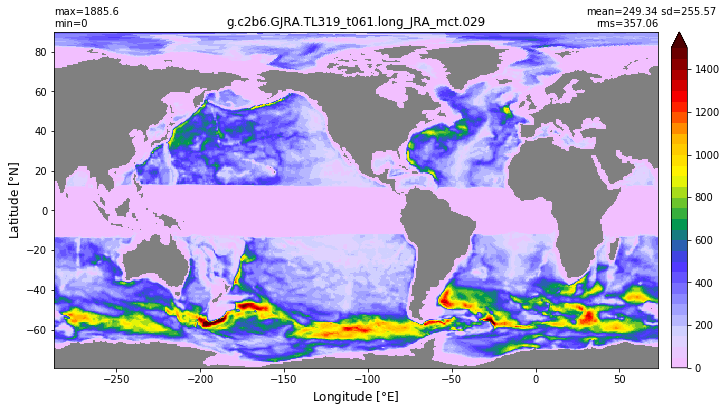

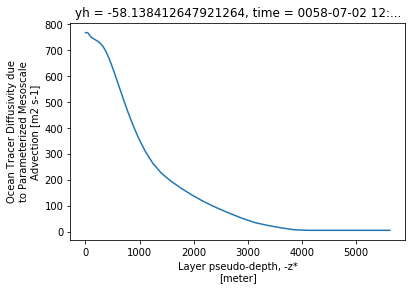

In [5]:
# GM coefficient
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[0]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[0]][0,:,j,i].plot(ax=ax)


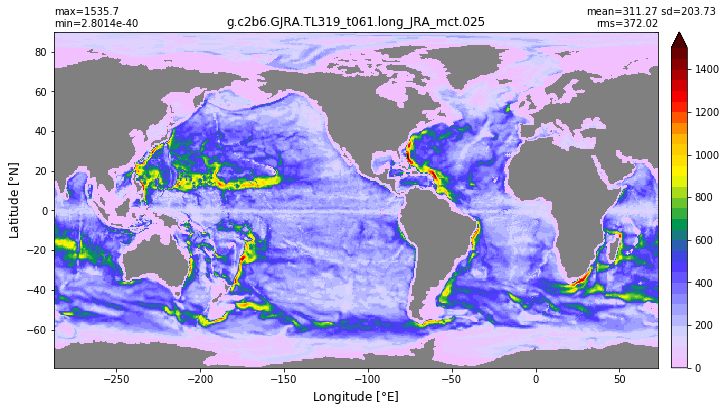

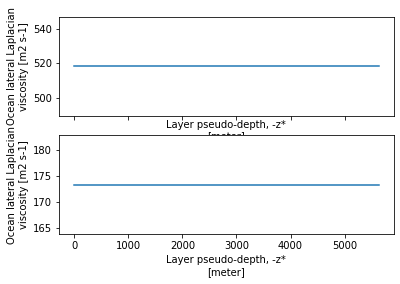

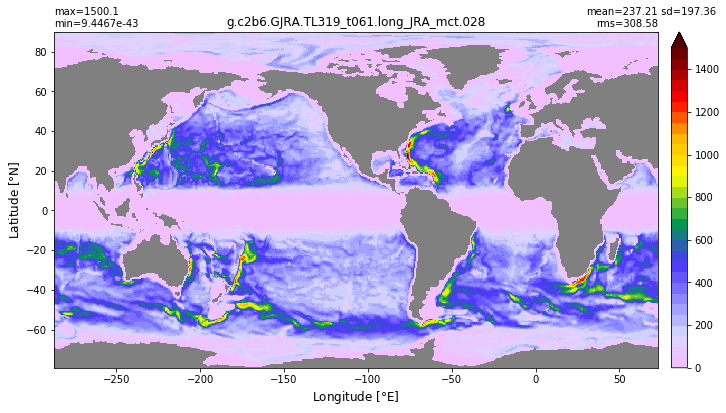

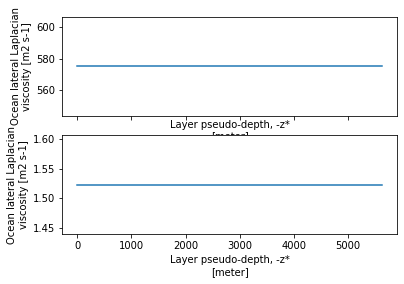

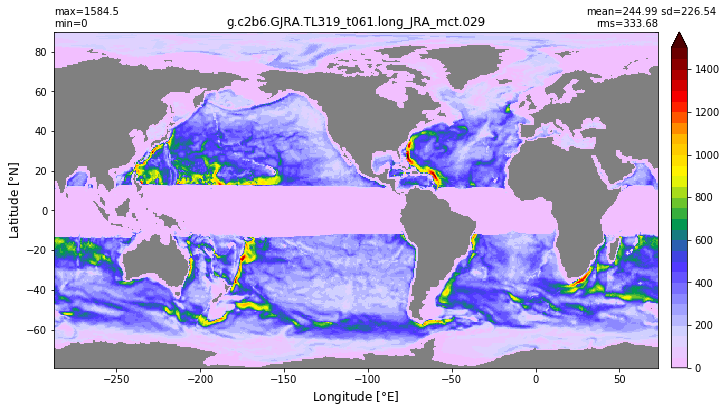

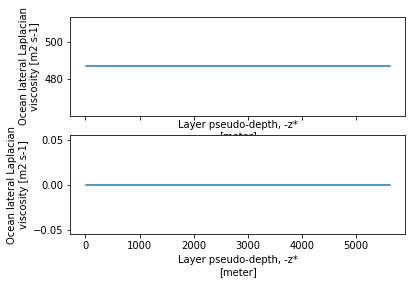

In [15]:
# Laplacian visc
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
# find point in the Equator, 180E
j2 = np.abs( grd.geolat[:,0] - 0.0 ).argmin()
i2 = np.abs( grd.geolon[0,:] - -180.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[1]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(2,1, sharex=True)
  ds[variables[1]][0,:,j,i].plot(ax=ax[0])
  ds[variables[1]][0,:,j2,i2].plot(ax=ax[1])
  ax[0].set_title(''); ax[1].set_title('')

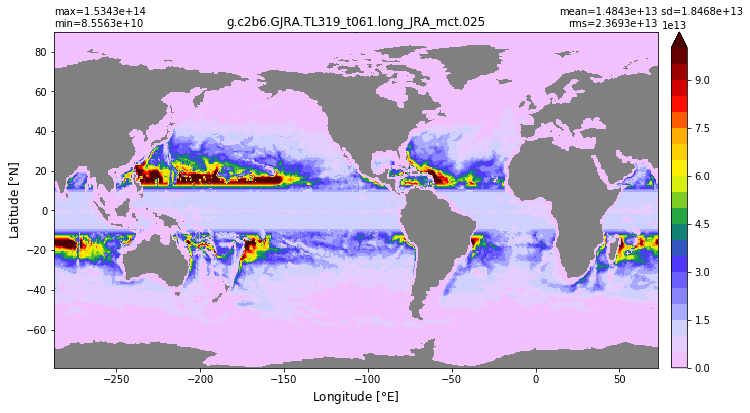

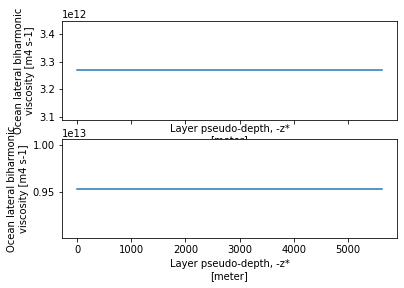

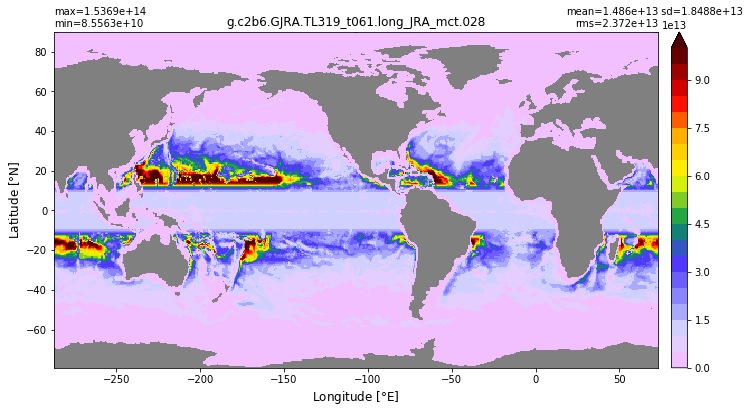

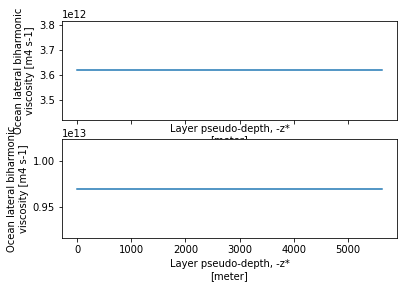

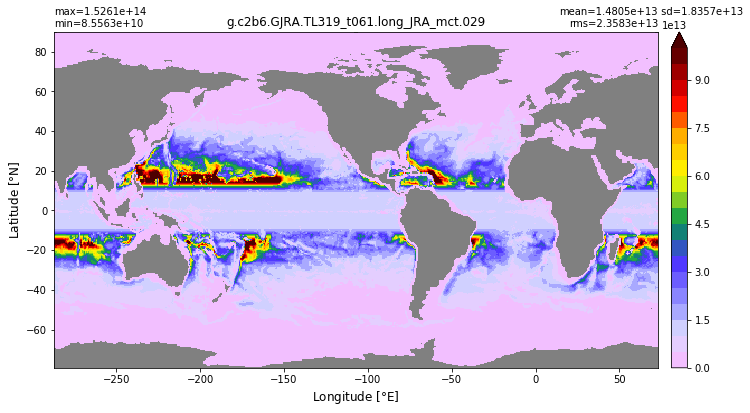

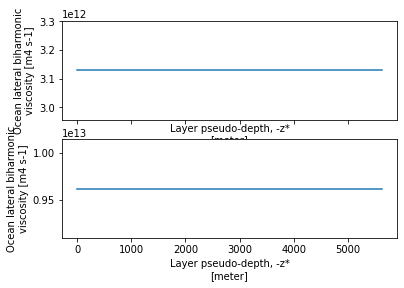

In [12]:
# Biharmonic
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
# find point in the Equator, 180E
j2 = np.abs( grd.geolat[:,0] - 0.0 ).argmin()
i2 = np.abs( grd.geolon[0,:] - -180.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[2]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(1.0e10,1.0e14), title=str(exps[exp]))
  
  f, ax = plt.subplots(2,1, sharex=True)
  ds[variables[2]][0,:,j,i].plot(ax=ax[0])
  ds[variables[2]][0,:,j2,i2].plot(ax=ax[1])
  ax[0].set_title(''); ax[1].set_title('')

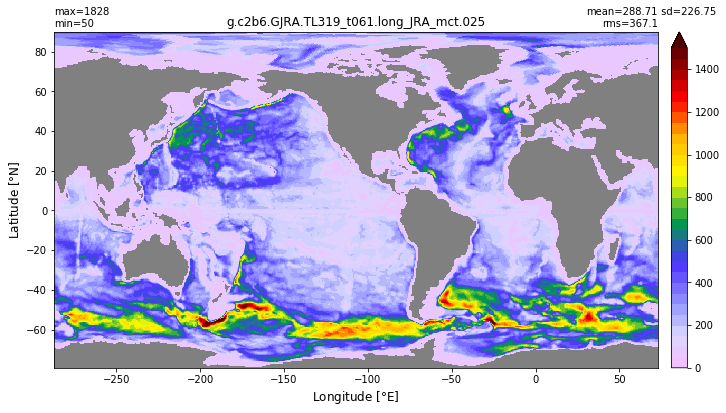

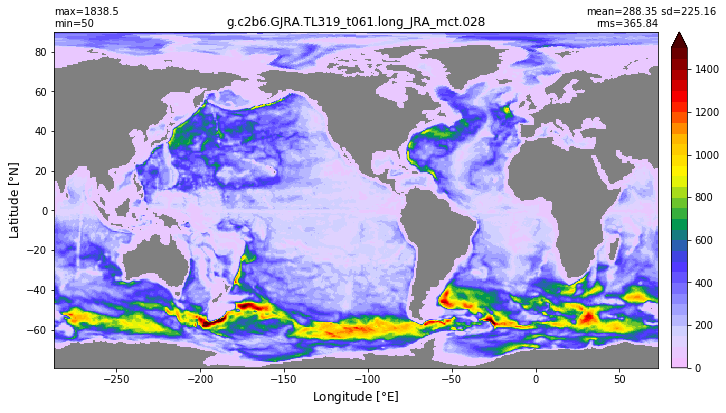

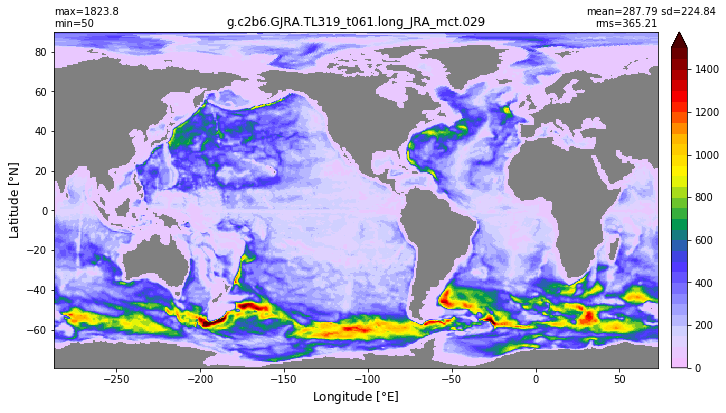

In [34]:
# KHTR (Redi)
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0058.nc')
  xyplot(np.ma.masked_invalid(ds[variables[3]][0,:].values), grd.geolon, grd.geolat, clim=(0, 1500), area=grd.area_t, title=str(exps[exp]))

## 1.9 Sea Ice


### Ice thickness

<center> <font size="4">Atlantic</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/contour/con_ann_hi_cice.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.028/contour/con_ann_hi_cice.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.029/contour/con_ann_hi_cice.png'></td>
    </tr>
</table>

### Ice concentration

<center> <font size="4">Atlantic</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.024/contour/con_ann_aice_cice.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/contour/con_ann_aice_cice.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.026/contour/con_ann_aice_cice.png'></td>
    </tr><tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.027/contour/con_ann_aice_cice.png'></td>
    </tr>
</table>

<center> <font size="4">Sea ice extent climatology NH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.024/line/clim_mo_NH.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/clim_mo_NH.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.026/line/clim_mo_NH.png'></td>
    </tr><tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.027/line/clim_mo_NH.png'></td>
    </tr>
</table>

<center> <font size="4">Sea ice extent climatology SH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.024/line/clim_mo_SH.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/clim_mo_SH.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.026/line/clim_mo_SH.png'></td>
    </tr><tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.027/line/clim_mo_SH.png'></td>
    </tr>
</table>

<center> <font size="4">Sea ice extent time-series NH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.024/line/line_mo_NH.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/line_mo_NH.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.026/line/line_mo_NH.png'></td>
    </tr><tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.027/line/line_mo_NH.png'></td>
    </tr>
</table>

<center> <font size="4">Sea ice extent time-series SH</font></center>
<table>
    <tr>
    <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.024/line/line_mo_SH.png'></td>
    </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/line/line_mo_SH.png'></td>
   </tr> <tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.026/line/line_mo_SH.png'></td>
    </tr><tr>
     <td><img src='../g.c2b6.GJRA.TL319_t061.long_JRA_mct.027/line/line_mo_SH.png'></td>
    </tr>
</table>